In [1]:
from sklearn.decomposition import PCA
import tensorflow as tf
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from sklearn.utils import shuffle
from skimage import filters
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from sklearn.metrics import accuracy_score

from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

In [2]:
import os

In [3]:
def show_before_and_after(before,after):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(before,plt.cm.gray)
    plt.title('Before')
    plt.subplot(1,2,2)
    plt.imshow(after,plt.cm.gray)
    plt.title('After')
    plt.show()


In [4]:
def convert_to_grayscale(image):
    gray_scale_img=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    return gray_scale_img

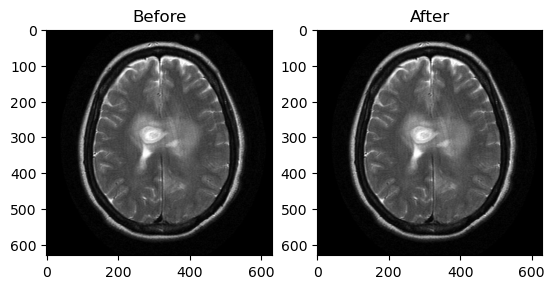

In [5]:
#Converting to gray scale 
sample_img=cv2.imread("E:\download\BTRIAL\Brain-tumor-datasets-master\yes\Y9.jpg")
gray_scale_img_of_sample=convert_to_grayscale(sample_img)
show_before_and_after(sample_img,gray_scale_img_of_sample)


In [6]:
#Reduces image size and down sampling the image
def gaussian_blur(image):
    return cv2.GaussianBlur(image,(5,5),0)

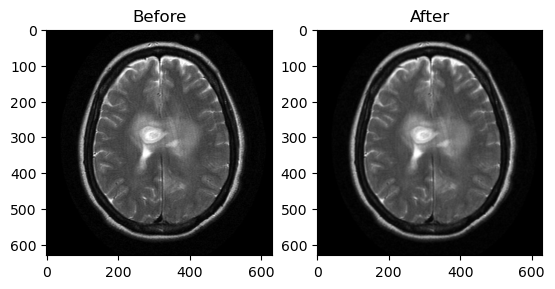

In [7]:
#Blurring the image
slightly_blurred_image=gaussian_blur(gray_scale_img_of_sample)
show_before_and_after(gray_scale_img_of_sample,slightly_blurred_image)

In [8]:
def threshold_image(image):
    ret,th=cv2.threshold(image,45,255,cv2.THRESH_BINARY)
    return th

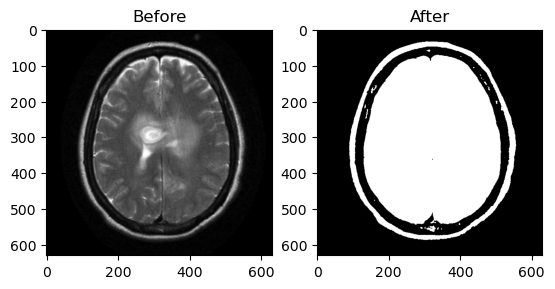

In [9]:
#Thresholding image
#A method of image segmentation which segments foreground from background
thresh_image=threshold_image(slightly_blurred_image)
#show_before_and_after(slightly_blurred_image,thresh_image)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(slightly_blurred_image,plt.cm.gray)
plt.title('Before')
plt.subplot(1,2,2)
plt.imshow(thresh_image,plt.cm.gray)
plt.title('After')
plt.show()


In [10]:
def erode_image(image):
     return cv2.erode(image, None, iterations=2)
    

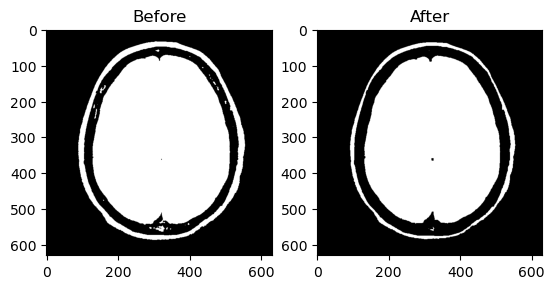

In [11]:
#Eroding image
#The basic idea of erosion is just like soil erosion only, it erodes away the boundaries of foreground object
eroded_img=erode_image(thresh_image)

show_before_and_after(thresh_image,eroded_img)

In [12]:
def dilate_img(image):
    return cv2.dilate(image, None, iterations=2)

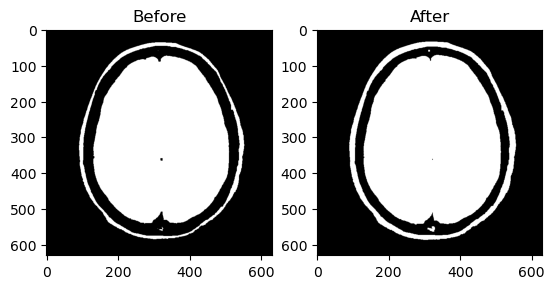

In [13]:
#Dilating image
#Dilation adds pixels to object boundaries
dilated_img=dilate_img(eroded_img)
show_before_and_after(eroded_img,dilated_img)

In [14]:
def crop_image_coordinates(image,plot=False):
    #Grabbing largest contours
    cntrs=cv2.findContours(image.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cntrs = imutils.grab_contours(cntrs)
    largest_cntr = max(cntrs, key=cv2.contourArea)
    #Extreme points finding for cropping
    ext_left = tuple(largest_cntr[largest_cntr[:, :, 0].argmin()][0])
    ext_right = tuple(largest_cntr[largest_cntr[:, :, 0].argmax()][0])
    ext_top = tuple(largest_cntr[largest_cntr[:, :, 1].argmin()][0])
    ext_bot = tuple(largest_cntr[largest_cntr[:, :, 1].argmax()][0])
    return [ext_left,ext_right,ext_top,ext_bot]
    

In [15]:
def crop_image(image,crop_image_coords):
    return image[crop_image_coords[2][1]:crop_image_coords[3][1], crop_image_coords[0][0]:crop_image_coords[1][0]]

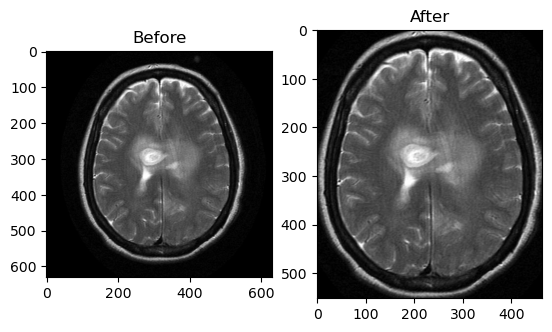

In [16]:
#Cropping only the brain image
coords=crop_image_coordinates(dilated_img)
cropped_image=crop_image(sample_img,coords)
show_before_and_after(sample_img,cropped_image)

In [17]:
def resize_image(image,size):
    width,height=size
    return cv2.resize(image, dsize=(width, height), interpolation=cv2.INTER_CUBIC)


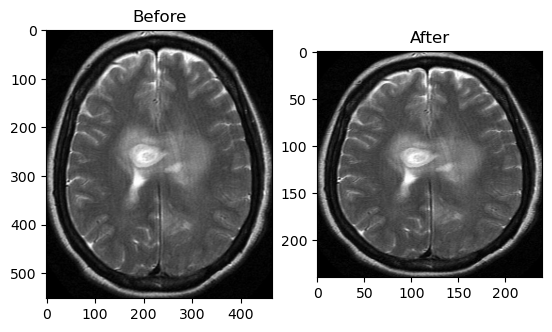

In [18]:
#Resizing image
resized_image=resize_image(cropped_image,[240,240])
show_before_and_after(cropped_image,resized_image)

In [19]:
def normalize_image(image):
    return image/255


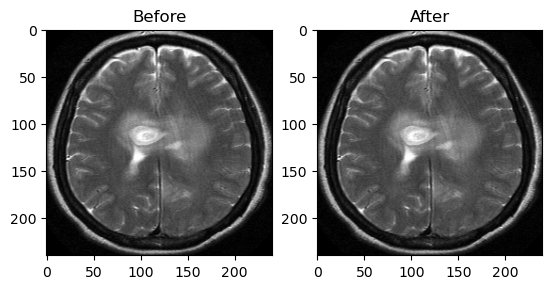

In [20]:
#Normalizing image
normalized_image=normalize_image(resized_image)
show_before_and_after(resized_image,normalized_image)

In [21]:
def prepare_image(image):
    return normalize_image(resize_image(crop_image(image,crop_image_coordinates(dilate_img(erode_image(threshold_image(gaussian_blur(convert_to_grayscale(image))))))),[240,240]))

In [22]:

# Performing above steps on the whole dataset
def load_data(directory_list, image_size):

    # load all images in a directory
    Image = []
    label = []
    width, height = image_size
    
    for directory in directory_list:
        for filename in os.listdir(directory):
            #load the image
            
            image = cv2.imread(directory + '/' + filename)
            image = prepare_image(image)
            Image.append(image)
            # append a value of 1 to the label array if the image
            # is in the folder named 'yes', else append 0.
            if directory[-3:] == 'yes':
                label.append([1])
            else:
                label.append([0])
                
    Image = np.array(Image)
    label = np.array(label)
    
    # Shuffle the data
    Image, label = shuffle(Image, label)
    
    
    
    return Image, label

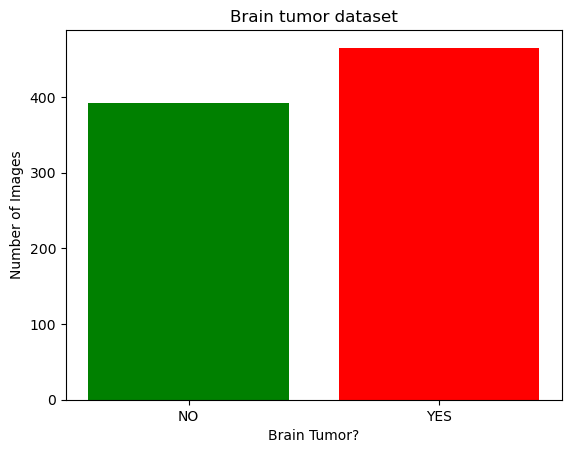

In [56]:
#Visualization1 - Number of tumor scans
#data_path="E:\download\BTRIAL\Brain-tumor-datasets-master"
# data_path_yes=r"E:/download/bdata/Brain-tumor-datasets-master/yes"
# data_path_no=r"E:/download/bdata/Brain-tumor-datasets-master/no"
data_path_yes=r"E:/download/BTRIAL/aug/yes"
data_path_no=r"E:/download/BTRIAL/aug/no"
width,height=(240,240)
Image,label=load_data([data_path_yes,data_path_no],[width,height])
label_list=label.tolist()
no_yes_count=[0,0]
for i in range(len(label_list)):
    no_yes_count[label_list[i][0]]+=1
xaxis=["NO","YES"]
yaxis=no_yes_count
plt.figure()
plt.bar(xaxis,yaxis,color=['green','red'])
plt.xlabel("Brain Tumor?")
plt.ylabel("Number of Images")
plt.title("Brain tumor dataset")
plt.show()



In [24]:
no_yes_count

[392, 465]

In [27]:
Image.shape[0]

857

In [28]:
l=[]
for image_no in range((Image.shape)[0]):
    l.append(Image[image_no].ravel())
df=pd.DataFrame(l,columns=[i for i in range(len(l[0]))])
df["Target"]=label
df.head()

,0,1,2,3,4,5,6,7,8,9,...,172791,172792,172793,172794,172795,172796,172797,172798,172799,Target
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007843,0.007843,0.007843,1
1,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,...,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
4,0.050980,0.050980,0.050980,0.050980,0.050980,0.050980,0.050980,0.050980,0.050980,0.050980,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1


In [29]:
df.shape

(857, 172801)

In [30]:

X=df[df.columns[0:-1]]
y=df['Target']

In [31]:
#Train and test split
X_train,X_test,Y_train,Y_test=train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train


,0,1,2,3,4,5,6,7,8,9,...,172790,172791,172792,172793,172794,172795,172796,172797,172798,172799
196,0.054902,0.054902,0.054902,0.054902,0.054902,0.054902,0.054902,0.054902,0.054902,0.054902,...,0.027451,0.035294,0.035294,0.035294,0.039216,0.039216,0.039216,0.043137,0.043137,0.043137
645,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
122,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
851,0.780392,0.780392,0.780392,0.760784,0.760784,0.760784,0.584314,0.584314,0.584314,0.478431,...,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843,0.007843
167,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922
192,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
629,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
559,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.721569,0.525490,0.525490,0.525490,0.313725,0.313725,0.313725,0.184314,0.184314,0.184314


In [32]:
pca = PCA(n_components = 685)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [33]:
#Limited memory Broyden–Fletcher–Goldfarb–Shanno
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(32,16,8,4,2), random_state=0)
clf.fit(X_train, Y_train)
y_pred=clf.predict(X_test)
confusion_matrix(Y_test,y_pred)
mlp_acc=accuracy_score(Y_test,y_pred)
print(mlp_acc)

0.75


In [34]:
model_svm=svm.SVC()
model_svm.fit(X_train,Y_train)
y_pred=model_svm.predict(X_test)
confusion_matrix(Y_test,y_pred)
svm_acc=accuracy_score(Y_test,y_pred)
print(svm_acc)

0.7093023255813954


In [35]:
dtree=DecisionTreeClassifier(max_depth=10,random_state=0)
model=dtree.fit(X_train,Y_train)
y_pred=model.predict(X_test)
confusion_matrix(Y_test,y_pred)
dtree_acc=accuracy_score(Y_test,y_pred)
print(dtree_acc)

0.6337209302325582


In [36]:
rtree=RandomForestClassifier(n_estimators=128,random_state=0)
model=rtree.fit(X_train,Y_train)
y_pred=model.predict(X_test)
confusion_matrix(Y_test,y_pred)
rtree_acc=accuracy_score(Y_test,y_pred)
print(rtree_acc)

0.6686046511627907


In [37]:
lr=LogisticRegression(max_iter=250)
model=lr.fit(X_train,Y_train)
y_pred=model.predict(X_test)
confusion_matrix(Y_test,y_pred)
lr_acc=accuracy_score(Y_test,y_pred)

In [38]:
xc=XGBClassifier()
model=xc.fit(X_train,Y_train)
y_pred=model.predict(X_test)
confusion_matrix(Y_test,y_pred)
xc_acc=accuracy_score(Y_test,y_pred)

In [39]:
model_1 = XGBClassifier()
model_2 = LogisticRegression(max_iter=200)
model_3 = svm.SVC(kernel="poly",probability=True)
model_4=MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(64,32,16,8,4,2), random_state=0)
model_5=svm.SVC(kernel="rbf",probability=True)
final_model = VotingClassifier(estimators=[('XGB', model_1), ('LR', model_2), ('svm1', model_3),('MLP',model_4),('svm2',model_5)], voting='hard')
final_model.fit(X_train,Y_train)
y_pred=final_model.predict(X_test)
confusion_matrix(Y_test,y_pred)
ensem_acc=accuracy_score(Y_test,y_pred)

In [40]:
def build_model(input_shape): 
    X_input = Input(input_shape)
    X = ZeroPadding2D((2, 2))(X_input) 
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((4, 4), name='max_pool0')(X)  
    X = MaxPooling2D((4, 4), name='max_pool1')(X) 
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X) 
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    return model

In [52]:
X_train_,X_test_,Y_train_,Y_test_=train_test_split(Image, label, test_size = 0.2, random_state = 0)
model_cnn=build_model((240,240,3))
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cnn.fit(x=X_train_, y=Y_train_, batch_size=32, epochs=20)

Epoch 1/20
22/22 [==============================] - 38s 2s/step - loss: 0.8213 - accuracy: 0.6175
Epoch 2/20
22/22 [==============================] - 36s 2s/step - loss: 0.6203 - accuracy: 0.6934
Epoch 3/20
22/22 [==============================] - 36s 2s/step - loss: 0.4656 - accuracy: 0.7723
Epoch 4/20
22/22 [==============================] - 36s 2s/step - loss: 0.4118 - accuracy: 0.8044
Epoch 5/20
22/22 [==============================] - 36s 2s/step - loss: 0.4358 - accuracy: 0.8131
Epoch 6/20
22/22 [==============================] - 38s 2s/step - loss: 0.3264 - accuracy: 0.8613
Epoch 7/20
22/22 [==============================] - 41s 2s/step - loss: 0.3028 - accuracy: 0.8555
Epoch 8/20
22/22 [==============================] - 44s 2s/step - loss: 0.3258 - accuracy: 0.8628
Epoch 9/20
22/22 [==============================] - 40s 2s/step - loss: 0.3325 - accuracy: 0.8526
Epoch 10/20
22/22 [==============================] - 38s 2s/step - loss: 0.2478 - accuracy: 0.8964
Epoch 11/20
22/22 [

In [55]:
loss, cnn_acc = model_cnn.evaluate(x=X_test_, y=Y_test_)

6/6 [==============================] - 2s 366ms/step - loss: 0.5692 - accuracy: 0.7616


In [43]:
cnn_acc

0.7616279125213623

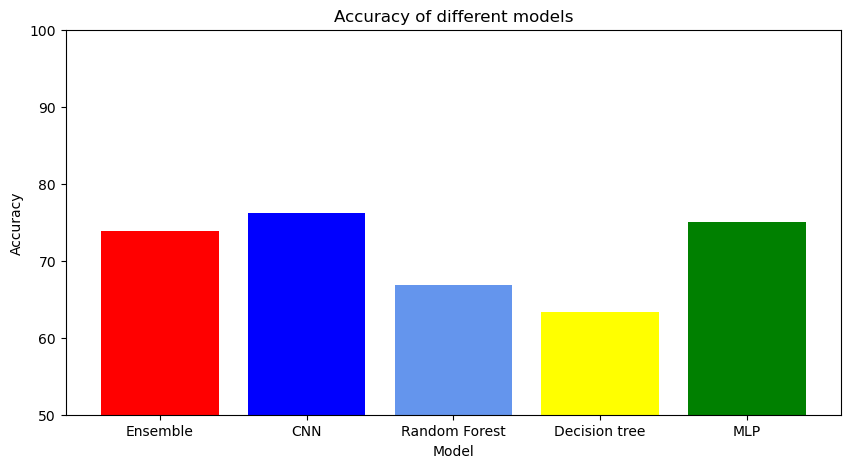

In [45]:
xaxis=["Ensemble","CNN","Random Forest","Decision tree","MLP"]
yaxis=[ensem_acc*100,cnn_acc*100,rtree_acc*100,dtree_acc*100,mlp_acc*100]
plt.figure(figsize=(10,5))
plt.bar(xaxis,yaxis,color=['red','blue','Cornflowerblue','yellow','green'])
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Accuracy of different models")
plt.ylim([50,100])
plt.show()


In [46]:
yaxis

[73.83720930232558,
 76.16279125213623,
 66.86046511627907,
 63.372093023255815,
 75.0]

In [47]:
import pickle

In [48]:
#Saving Ensemble
filename='ensemble_model.sav'
pickle.dump(final_model,open(filename,'wb'))

In [49]:
#Saving PCA
filename='pca_model.sav'
pickle.dump(pca,open(filename,'wb'))

In [50]:
#Saving CNN
filename='model_cnn2.sav'
pickle.dump(model_cnn,open(filename,'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\activation
......vars
...layers\batch_normalization
......vars
.........0
.........1
.........2
.........3
...layers\conv2d
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\flatten
......vars
...layers\input_layer
......vars
...layers\max_pooling2d
......vars
...layers\max_pooling2d_1
......vars
...layers\zero_padding2d
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-03-07 01:46:58         3531
metadata.json                                  2023-03-07 01:46:58   